In [1]:
import ImageD11.sinograms.dataset
import ImageD11.sinograms.properties
import ImageD11.sparseframe
import ImageD11.blobcorrector
import ImageD11.columnfile
import ImageD11.indexing
import ImageD11.refinegrains
import h5py
import pylab as pl
import numpy as np
import os, sys

if '/home/esrf/jean1994b/3DXRD_apr23/SCRIPTS' not in sys.path:
    sys.path.append('/home/esrf/jean1994b/3DXRD_apr23/SCRIPTS')
    
from id11_utils import peakfiles

In [2]:
### define data path
experiment = '/home/esrf/jean1994b/3DXRD_apr23/'
sample = 'stdquartzrpt'
dset = 'fine'

spname = '_'.join([sample,dset,'sparse.h5']) 
sppath = os.path.join(experiment, 'PROCESSED_DATA/SPARSEPIXELS', sample, spname)

# path to save filtered pks, ds, ubi files etc. for a given dataset
pksname = os.path.join(experiment, 'PROCESSED_DATA/ANALYSIS', sample, spname.replace('sparse','pks'))
dsname = pksname.replace('pks','ds')

spname, sppath, pksname, dsname

('stdquartzrpt_fine_sparse.h5',
 '/home/esrf/jean1994b/3DXRD_apr23/PROCESSED_DATA/SPARSEPIXELS/stdquartzrpt/stdquartzrpt_fine_sparse.h5',
 '/home/esrf/jean1994b/3DXRD_apr23/PROCESSED_DATA/ANALYSIS/stdquartzrpt/stdquartzrpt_fine_pks.h5',
 '/home/esrf/jean1994b/3DXRD_apr23/PROCESSED_DATA/ANALYSIS/stdquartzrpt/stdquartzrpt_fine_ds.h5')

In [ ]:
# list datasets to process
spnames = sorted( [sp for sp in os.listdir(os.path.dirname(sppath)) if 'sparse' in sp] )
TO_DO = [sp for sp in spnames if sp.split('_sparse')[0] not in os.listdir()]
TO_DO

In [ ]:
# create dataset object and save it in hdf
ds = ImageD11.sinograms.dataset.import_from_sparse(sppath)
ds.save(dsname)
ds.scans

In [6]:
# load 2D peaktable and merge 2D peaks to 4D peaks (tth, eta, omega, dty)
pkst = ImageD11.sinograms.properties.pks_table_from_scan( sppath,ds,0)
pk4d = pkst.pk2dmerge( ds.omega, ds.dty )

coo : 0.001909 /s
find connected components : 0.015335 /s


In [10]:
# load data in an imageD11 colfile
cf = ImageD11.columnfile.colfile_from_dict( ImageD11.blobcorrector.eiger_spatial()(pk4d) )
parfile = 'quartz.par'

cf.parameters.loadparameters(parfile)
cf.updateGeometry()

uc, d, hkls, tth_calc, wl = peakfiles.get_uc(cf, parfile)

print('Total size =', peakfiles.get_colf_size(cf), 'MB')

Total size = 4.46 MB


Text(0, 0.5, 'eta deg')

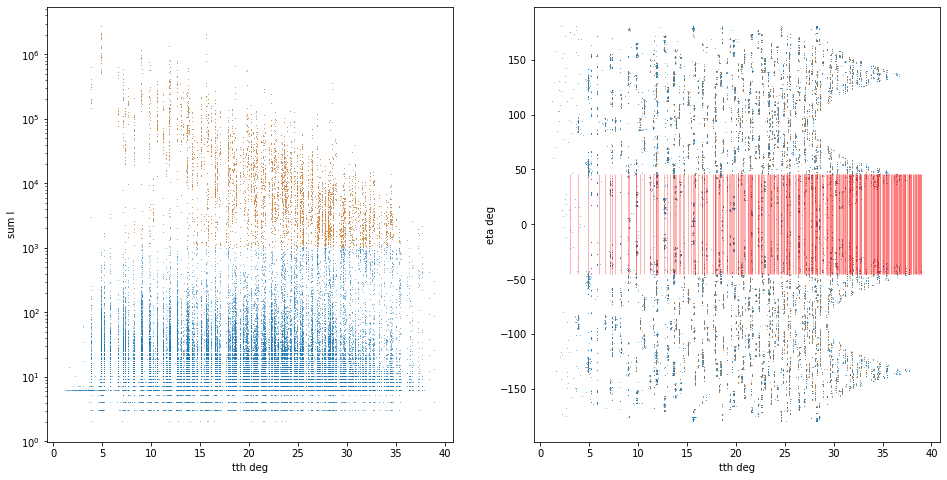

In [11]:
# plot tth vs eta + tth vs I
# you can use define some mask here
mask = np.all([cf.Number_of_pixels > 50, cf.sum_intensity > 1e3], axis=0)

fig = pl.figure(figsize=(16,8))

fig.add_subplot(121)
pl.plot(cf.tth, cf.sum_intensity,',', alpha=0.5)
pl.plot(cf.tth[mask], cf.sum_intensity[mask],',', alpha=0.5)
#pl.plot(tth_calc, np.full(len(tth_calc),cf.sum_intensity.mean()), "|",ms=1e2, linewidth=.1, color='r', alpha=.3)
pl.semilogy()
pl.xlabel('tth deg')
pl.ylabel('sum I')

fig.add_subplot(122)
pl.plot(cf.tth, cf.eta,',', alpha=0.5)
pl.plot(cf.tth[mask], cf.eta[mask],',', alpha=0.5)
pl.plot(tth_calc, np.full(len(tth_calc),0), "|", ms=100, linewidth=.1, color='r', alpha=.3)
pl.xlabel('tth deg')
pl.ylabel('eta deg')


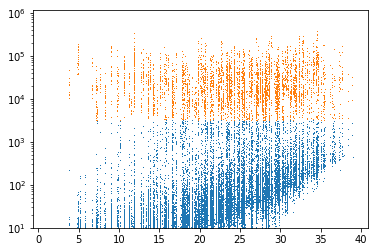

In [13]:
# select strong peaks
cf.addcolumn( ImageD11.refinegrains.lf(cf.tth, cf.eta), 'lf' )  # Lorentz scaling factor for intensity
B = 1.
tfac = np.exp( B * cf.ds**2 )

mask = cf.sum_intensity*cf.lf*tfac >  3e3 

pl.figure()
pl.plot(cf.tth, cf.sum_intensity*cf.lf*tfac,',')
pl.plot(cf.tth[mask], cf.sum_intensity[mask]*cf.lf[mask]*tfac[mask],',')
pl.semilogy()
pl.ylim(10,)

strong  = cf.copy()
strong.filter(mask)

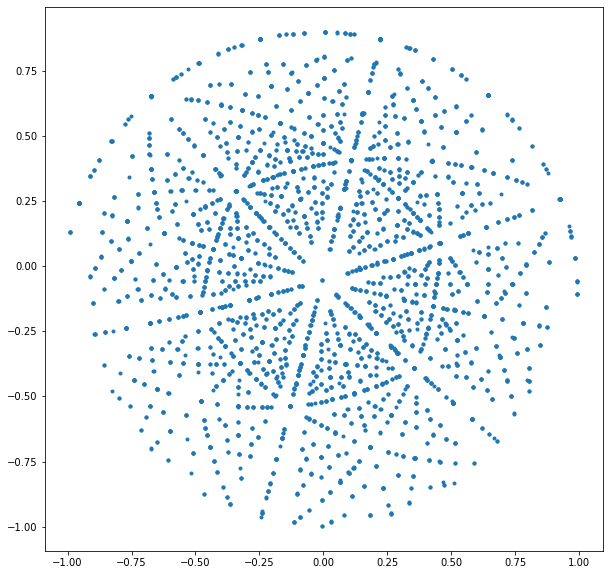

In [105]:
# look at gvectors on polefigure for strong peaks. should look like it is a single grain
pl.figure(figsize=(10,10))
den = (strong.ds + abs(strong.gz))
pl.plot(strong.gx*np.sign(strong.gz)/den,strong.gy*np.sign(strong.gz)/den,'.')
pl.savefig('quartz_strong_polefig.png', format='png')


In [67]:
# write separate peakfile with strong peaks
strong.writefile('quartz_strong.flt')

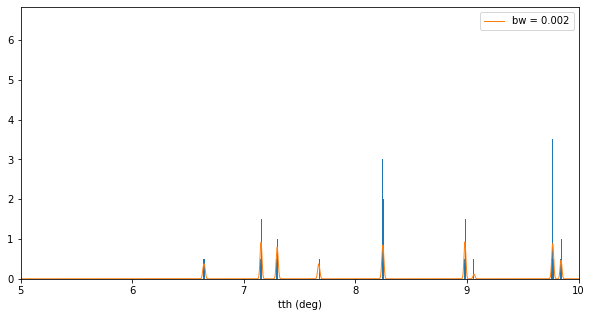

In [14]:
# compute tth histogram + kernel density estimation (kde)
from scipy.stats import gaussian_kde

strong.filter(strong.tth<20)

bw = 0.002  # bandwidth for kde
kde = gaussian_kde(strong.tth, bw_method=bw)

# resample ds values with given ds_step
ds_step = 0.0001
tth_step = np.arcsin( wl*ds_step/2 )*360/np.pi
x = np.arange(strong.tth.min(),strong.tth.max(),tth_step)
pdf = kde.pdf(x)

#plot
#pl.close('all')
pl.figure(figsize=(10,5))
pl.hist(strong.tth, bins=x, density=True);
pl.plot(x, pdf, '-', linewidth=1., label='bw = ' +str(bw))
pl.xlabel('tth (deg)')
pl.xlim(5,10)
pl.legend()


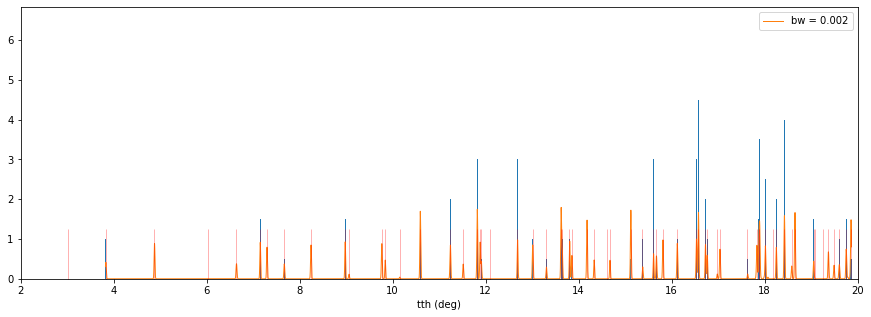

In [15]:
pl.figure(figsize=(15,5))
pl.hist(strong.tth, bins=x, density=True);
pl.plot(x, pdf, '-', linewidth=1., label='bw = ' +str(bw))
pl.xlabel('tth (deg)')
pl.plot(tth_calc, np.full(len(tth_calc),0), "|", ms=100, linewidth=.1, color='r', alpha=.3)
pl.xlim(2,20)
pl.legend()
pl.savefig('quartz_strong_XRDspec_fine.png', format='png')

In [16]:
# save xrd spectrum in txt file
fname = 'stdqtz_XRDspec_bw'+str(bw)+'_fine.xy'
f = open(fname,'w')
f.write('tth freq'+'\n')
for l in range(len(x)):
    f.write(format(x[l],'.4f')+' '+format(pdf[l],'.4f')+'\n')
f.close()

In [10]:
# load strong peaks for indexing
cf = ImageD11.columnfile.columnfile(os.path.join(experiment, sample, 'quartz_strong.flt'))

gv = np.transpose([cf.gx, cf.gy, cf.gz])  # g-vectors

# unit cell
cell = np.array([4.913,4.913,5.405,90,90,120])
uc = ImageD11.unitcell.unitcell( cell , 'P')

In [67]:
# prepare indexer
ImageD11.indexing.loglevel=0  # loglevel set to high value to avoid outputs from indexer
ind = ImageD11.indexing.indexer( unitcell =  ImageD11.unitcell.unitcell_from_parameters( cf.parameters ),
                                 gv = gv,
                                 wavelength=cf.parameters.get('wavelength'),
                                 hkl_tol= 0.1,
                                 cosine_tol = np.cos(np.radians(90-1.)),
                                 ds_tol = 0.005,
                                 minpks = 10,
                                      )

ind.assigntorings()

info: gv: [[-0.2955  0.4159  1.3431]
 [-0.0508 -0.1675 -0.5771]
 [-0.1024  0.4682 -0.6963]
 ...
 [-0.1015  0.469  -0.696 ]
 [-0.4085 -1.6246  0.1945]
 [-0.4525  1.4806  0.8958]] (4939, 3) float64
info: Assign to rings, maximum d-spacing considered: 2.340461
info: Ring assignment array shape (4939,)
info: Ring     (  h,  k,  l) Mult  total indexed to_index  ubis  peaks_per_ubi   tth
info: Ring 174 ( -8, -3, -2)   36      0       0        0   N/A     N/A  38.97
info: Ring 173 ( -4, -3,-10)   60      3       0        3   N/A     N/A  38.86
info: Ring 172 ( -4, -4, -9)   60      0       0        0   N/A     N/A  38.70
info: Ring 171 ( -8, -3, -1)   28      0       0        0   N/A     N/A  38.59
info: Ring 170 ( -8, -3,  0)   42      0       0        0   N/A     N/A  38.46
info: Ring 169 ( -9,  0, -5)   72      4       0        4   N/A     N/A  38.35
info: Ring 168 ( -5,  1,-11)   48      0       0        0   N/A     N/A  38.25
info: Ring 167 ( -9,  1, -6)   40      0       0        0   N/

In [70]:
# Indexing
###########################################################################
rings = []
ind.loglevel=3
for i, ds in enumerate(ind.unitcell.ringds[:15]): # select first nrings
    if len(ind.unitcell.ringhkls[ds]) <= 6 and (ind.ra == i).sum()>0:  # select low multiplicity rings with nonzero nb of peaks
        rings.append(i)

rings

[1, 4, 7, 14]

In [71]:
# loop through rings and try to find orientations
for r1 in rings[::-1]:
    for r2 in rings[::-1]:
        ind.ring_1 = r1
        ind.ring_2 = r2
        ind.find()
        if ind.hits is None or len(ind.hits) == 0:
            continue
        ind.scorethem()
   

info: no peaks left for those rings
info: no peaks left for those rings
info: no peaks left for those rings
info: no peaks left for those rings
info: no peaks left for those rings
info: no peaks left for those rings
info: no peaks left for those rings
info: no peaks left for those rings
info: no peaks left for those rings
info: no peaks left for those rings
info: no peaks left for those rings
info: no peaks left for those rings
info: no peaks left for those rings
info: no peaks left for those rings
info: no peaks left for those rings
info: no peaks left for those rings


In [72]:
# see what was indexed
ind.assigntorings()

info: Assign to rings, maximum d-spacing considered: 2.340461
info: Ring assignment array shape (4939,)
info: Ring     (  h,  k,  l) Mult  total indexed to_index  ubis  peaks_per_ubi   tth
info: Ring 174 ( -8, -3, -2)   36      0       0        0   N/A     N/A  38.97
info: Ring 173 ( -4, -3,-10)   60      3       3        0   N/A     N/A  38.86
info: Ring 172 ( -4, -4, -9)   60      0       0        0   N/A     N/A  38.70
info: Ring 171 ( -8, -3, -1)   28      0       0        0   N/A     N/A  38.59
info: Ring 170 ( -8, -3,  0)   42      0       0        0   N/A     N/A  38.46
info: Ring 169 ( -9,  0, -5)   72      4       4        0   N/A     N/A  38.35
info: Ring 168 ( -5,  1,-11)   48      0       0        0   N/A     N/A  38.25
info: Ring 167 ( -9,  1, -6)   40      0       0        0   N/A     N/A  38.11
info: Ring 166 ( -8,  0, -7)   32      0       0        0   N/A     N/A  37.91
info: Ring 165 ( -8, -2, -4)   44      0       0        0   N/A     N/A  37.82
info: Ring 164 ( -9, 

In [73]:
# ubi matrix of indexed grain
ind.ubis

[array([[-1.33675102,  4.70212488,  0.48479552],
        [ 4.76129457, -1.20512735, -0.06822099],
        [ 0.06887353,  0.57241791, -5.37375863]])]

In [77]:
# run score and refine to be sure
ubi = ind.ubis[0]
ImageD11.cImageD11.score_and_refine( ubi, gv, hkltol ) 

(4921, 3.1128928842418714e-05)

In [83]:
# compute fitted unitcell
import xfab
xfab.tools.ubi_to_cell(ind.ubis[0])

array([  4.91224538,   4.91183652,   5.40468236,  89.99033156,
        90.01214531, 119.99790535])